<a href="https://colab.research.google.com/github/jazaineam1/nopara/blob/main/Cuadernos/Kolmogorov_Smirnov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Comparación de distribuciones: test Kolmogorov–Smirnov**

## ***Fundación Universidad de América***
>## **Estadística y Ciencias Actuariales**
>## ***Estadística No Paramétrica***
<img src="https://congresoambiental.car.gov.co/wp-content/uploads/2022/08/uniAmerica.png" alt="Imágen1" width="600" height="200">


Este documento explora diferentes métodos para evaluar y comparar distribuciones, lo que puede ser útil en diversas situaciones prácticas, tales como:

- **Análisis Descriptivo**: Analizar si una variable tiene distintas distribuciones entre dos grupos o si dos variables difieren en sus distribuciones.
  
- **Control de Modelos en Producción**: En la implementación de modelos (de predicción, agrupación, detección de anomalías, etc.), generalmente se utilizan datos históricos suponiendo que las variables mantendrán un comportamiento similar en el futuro. Este documento discute cómo identificar cuando esto deja de ser cierto y las variables empiezan a comportarse de manera diferente, lo cual puede ser una señal para reentrenar los modelos.

- **Comparación entre Escenarios en el Sector Industrial**: Es común que existan diferencias en los resultados entre diferentes líneas de producción, aunque se supone que ejecutan el mismo proceso. Comparar las variables de cada línea puede ayudar a encontrar las causas de estas diferencias.

La comparación de distribuciones puede abordarse de varias maneras. Una estrategia convencional implica comparar medidas de centralidad (como la media o la mediana) o de dispersión (como la desviación estándar o el rango intercuartílico), lo que es directo y fácil de interpretar pero puede pasar por alto diferencias significativas si solo se enfoca en un aspecto de la distribución.

Otra metodología implica evaluar la "distancia" entre distribuciones, utilizando estadísticas como la prueba de Kolmogorov-Smirnov, que considera tanto la ubicación como la forma de las distribuciones.

No existe una técnica definitiva que siempre sea la mejor; la elección dependerá de los cambios específicos que se necesiten detectar en las distribuciones.

Además, al comparar medidas como medias o medianas entre dos muestras, surge la cuestión de si las diferencias observadas son significativas o simplemente resultado de variaciones aleatorias. Aunque existen pruebas estadísticas, como el t-test para medias, que pueden calcular la probabilidad de observar una diferencia dada (o mayor) si no hubiera una diferencia real (p-value), estas pruebas a menudo requieren suposiciones que rara vez se cumplen en la práctica. Las técnicas de remuestreo, como la permutación y el bootstrapping, ofrecen alternativas que hacen menos suposiciones pero son más lentas.

Es crucial entender que el p-value ayuda a determinar la confianza en que una diferencia es real, pero no indica el tamaño de la diferencia. Por lo tanto, para la toma de decisiones, es importante considerar tanto la magnitud de la diferencia como el p-value de manera conjunta.

## Estadístico de Kolmogorov–Smirnov

El estadístico Kolmogorov–Smirnov, también referido como la distancia Kolmogorov–Smirnov, mide la máxima diferencia vertical entre las funciones de distribución acumulativa empíricas de dos conjuntos de datos, o entre una función de distribución acumulativa empírica y una teórica de referencia. Este indicador es particularmente útil por su capacidad de capturar variaciones tanto en la localización como en la forma de las distribuciones acumulativas.

![Imagen](https://raw.githubusercontent.com/jazaineam1/nopara/main/Images/SK/imagen1.png) ![Imagen2](https://raw.githubusercontent.com/jazaineam1/nopara/main/Images/SK/imagen2.png)

En las ilustraciones, la línea roja representa la función de distribución acumulativa teórica (CDF), la azul representa la función empírica (ECDF), y la flecha negra indica la magnitud del estadístico K-S.

### Ejemplo


El set de datos Snmesp del paquete plm contiene una muestra de los salarios (en escala logarítmica) pagados en España durante los años 1983 a 1990 (783 observaciones por año). Se pretende determinar si la distribución de los salarios cambió entre 1989 y 1993. Para ello se calcula la distancia de Kolmogorov–Smirnov.

In [4]:
install.packages('plm')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘miscTools’, ‘rbibutils’, ‘bdsmatrix’, ‘collapse’, ‘zoo’, ‘sandwich’, ‘lmtest’, ‘maxLik’, ‘Rdpack’, ‘Formula’




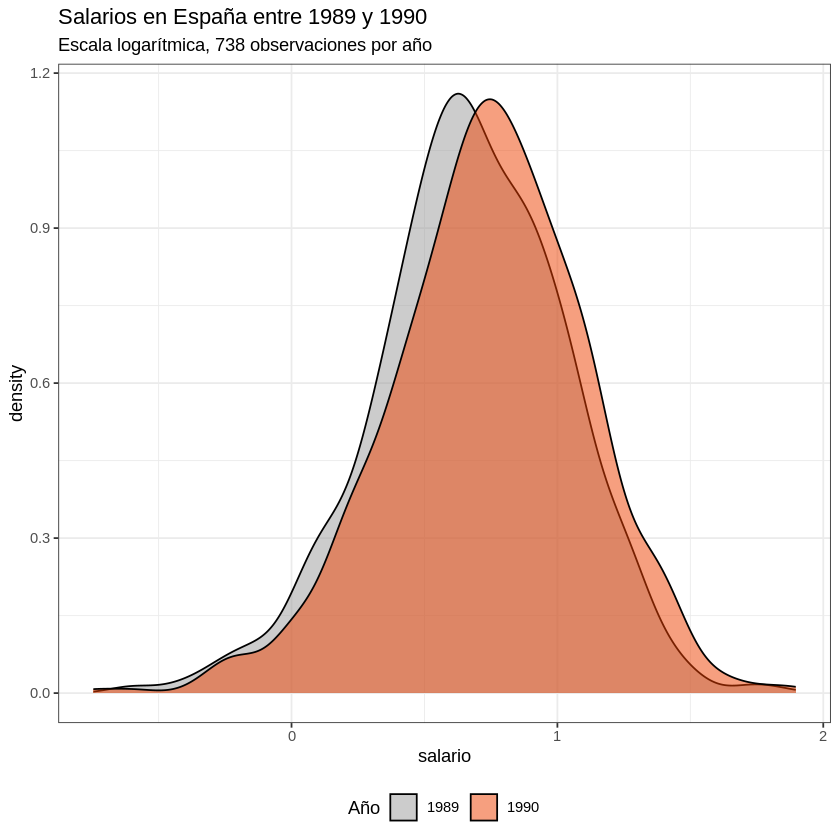

In [5]:
library(tidyverse)
data(Snmesp, package = "plm")

Snmesp <- Snmesp %>%
          filter(year %in% c(1989, 1990)) %>%
          mutate(year = as.factor(year)) %>%
          select(year, salario = w)
Snmesp %>%
    ggplot(aes(x = salario, fill = year)) +
    geom_density(alpha = 0.5) +
    scale_fill_manual(values = c("gray60", "orangered2")) +
    labs(title = "Salarios en España entre 1989 y 1990",
         subtitle = "Escala logarítmica, 738 observaciones por año",
         fill = "Año") +
    theme_bw() +
    theme(legend.position = "bottom")

### Cálculo de la función de distribución acumulada empírica

La función ecdf() permite ajustar la función de distribución acumulada empírica a partir de una muestra. El resultado de esta función es un objeto ecdf que se comporta de forma similar a un modelo predictivo, recibe un vector de observaciones y devuelve su probabilidad acumulada.

In [6]:
# Se ajustan las funciones ecdf con cada muestra.
ecdf_1989 <- ecdf(Snmesp %>% filter(year == 1989) %>% pull(salario))
ecdf_1990 <- ecdf(Snmesp %>% filter(year == 1990) %>% pull(salario))

# Se calcula la probabilidad acumulada de cada valor de salario observado con cada
# una de las funciones ecdf.
grid_salario <- unique(Snmesp %>% pull(salario))
prob_acumulada_ecdf_1989 <- ecdf_1989(v = grid_salario)
prob_acumulada_ecdf_1990 <- ecdf_1990(v = grid_salario)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


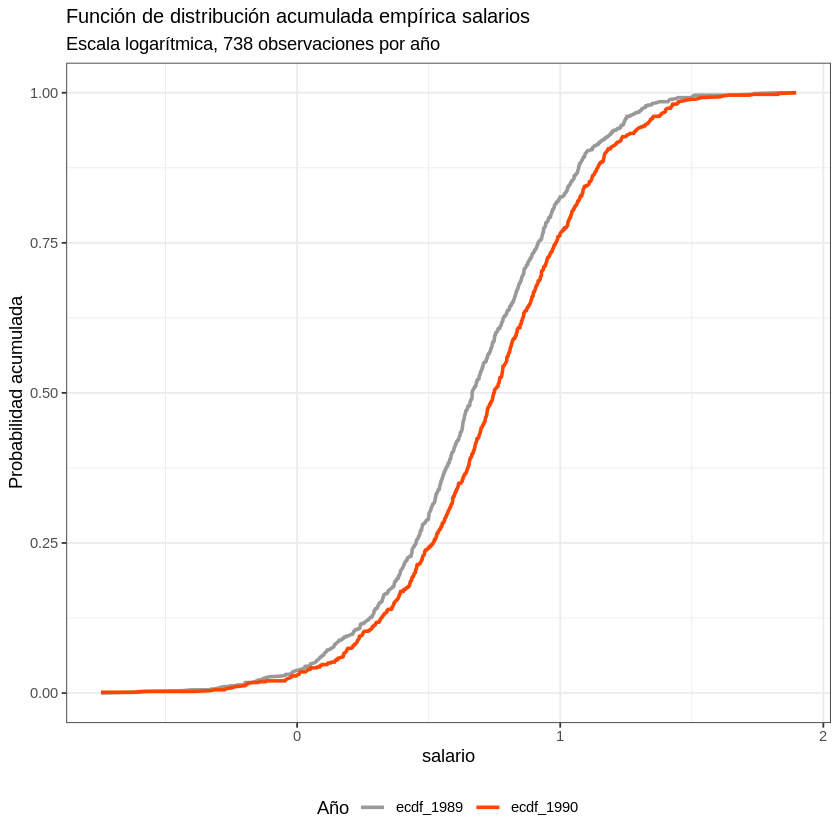

In [7]:
# Se unen los valores calculados en un dataframe.
df_ecdf <- data.frame(
            salario = grid_salario,
            ecdf_1989 = prob_acumulada_ecdf_1989,
            ecdf_1990 = prob_acumulada_ecdf_1990
           ) %>%
          pivot_longer(
            cols = c(ecdf_1989, ecdf_1990),
            names_to = "year",
            values_to = "ecdf"
          )

grafico_ecdf <- ggplot(data = df_ecdf,
                       aes(x = salario, y = ecdf, color = year)) +
                geom_line(size = 1) +
                scale_color_manual(values = c("gray60", "orangered1")) +
                labs(
                 title = "Función de distribución acumulada empírica salarios",
                 subtitle = "Escala logarítmica, 738 observaciones por año",
                 color = "Año",
                 y = "Probabilidad acumulada"
                ) +
                theme_bw() +
                theme(legend.position = "bottom",
                      plot.title = element_text(size = 12))

grafico_ecdf

Este mismo gráfico puede generarse directamente con stat_ecdf() de ggplot2.

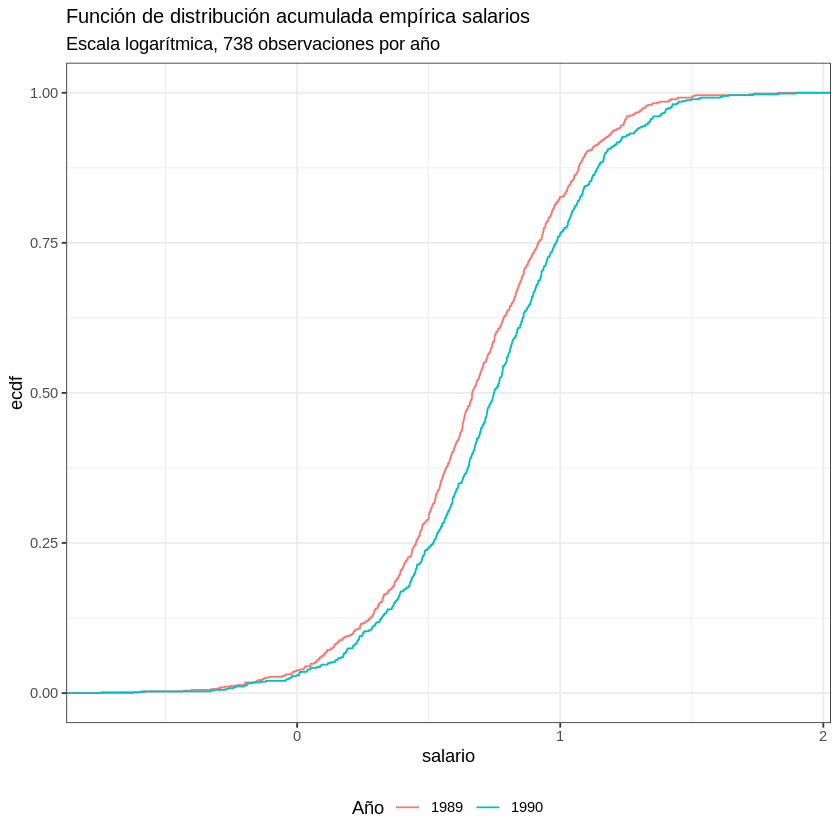

In [8]:
Snmesp %>%
    ggplot(aes(x = salario, color = year)) +
    stat_ecdf(geom = "step") +
    labs(title = "Función de distribución acumulada empírica salarios",
         subtitle = "Escala logarítmica, 738 observaciones por año",
         color = "Año") +
    theme_bw() +
    theme(legend.position = "bottom",
          plot.title = element_text(size=12))

### Cálculo de la distancia Kolmogorov–Smirnov

In [9]:
# Se calcula la diferencia absoluta entre las probabilidades acumuladas de cada
# función.
abs_dif <-  abs(prob_acumulada_ecdf_1989 - prob_acumulada_ecdf_1990)

# La distancia Kolmogorov–Smirnov es el máximo de las distancias absolutas.
distancia_ks <- max(abs_dif)
paste("Distancia Kolmogorov–Smirnov:", distancia_ks)

[1] "Distancia Kolmogorov–Smirnov: 0.105691056910569"

Se añade al gráfico anterior un segmento que representa la distancia Kolmogorov–Smirnov.

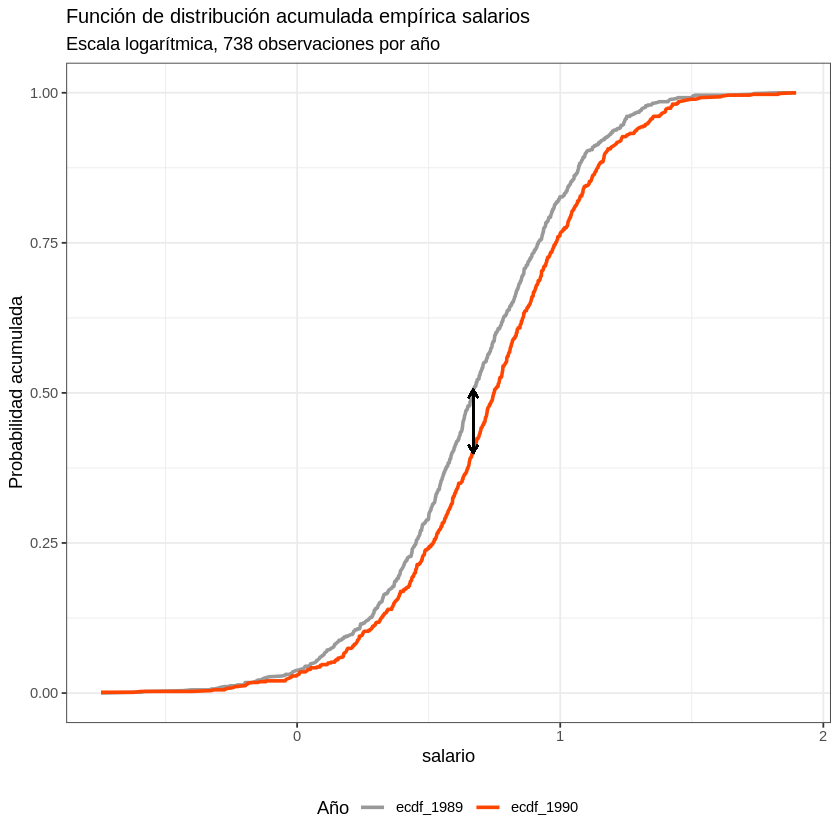

In [10]:
indice_ks <- which.max(abs_dif)

grafico_ecdf +
  geom_segment(aes(
                x = grid_salario[indice_ks],
                xend = grid_salario[indice_ks],
                y = prob_acumulada_ecdf_1989[indice_ks],
                yend = prob_acumulada_ecdf_1990[indice_ks]
               ),
               arrow = arrow(ends = "both", length = unit(0.2,"cm")),
               color = "black")

La función ks.test() del paquete stats calcula, como parte del test, la distancia de Kolmogorov–Smirnov. Se comprueba, a modo de validación, que ambos valores coinciden.

In [11]:
test <- ks.test(
        x = Snmesp %>% filter(year == 1989) %>% pull(salario),
        y = Snmesp %>% filter(year == 1990) %>% pull(salario)
      )
test$statistic

Warning message in ks.test.default(x = Snmesp %>% filter(year == 1989) %>% pull(salario), :
“p-value will be approximate in the presence of ties”


D 
0.1056911

## Test de Kolmogorov–Smirnov


Una vez calculada la distancia de Kolmogorov–Smirnov, hay que determinar si el valor de esta distancia es suficientemente grande, teniendo en cuenta las muestras disponibles, como para considerar que las dos distribuciones son distintas (p-value). Esto puede conseguirse calculando la probabilidad de observar distancias iguales o mayores si ambas muestras procediesen de la misma distribución, es decir, que las dos distribuciones son la misma.

Para el estadístico de Kolmogorov–Smirnov existen dos tipos de solución:

Solución analítica (exacta): si se cumple que las muestras son grandes y que no hay ligaduras, esta solución es mucho más rápida y genera p-values exactos. Esta solución está implementada en la función ks.test() del paquete stats.

Mediante un test de resampling: consiste en simular, mediante permutaciones o bootstrapping, las distancias de Kolmogorov–Smirnov que se obtendrían si ambas muestras procediesen de la misma distribución. Una vez obtenidas las simulaciones, se calcula el porcentaje de distancias iguales o mayores a la observada.

Algoritmo mediante permutación

1. Calcular la distancia Kolmogorov–Smirnov entre las dos muestras. Ha esta distancia se llama distancia observada.

2. Combinar todas las observaciones en un mismo vector.

3. Dividir aleatoriamente las observaciones en dos conjuntos del mismo tamaño que las muestras iniciales.

4. Calcular la distancia de Kolmogorov–Smirnov entre los dos nuevos conjuntos.

5. Repetir los pasos del 1 al 3 N veces.

6. Calcular la fracción de las N distancias simuladas iguales o superiores a la distancia observada. Este valor se corresponde con la estimación empírica del p-value.

La función ks.boot() de la librería Matching implementa la solución por resampling utilizando bootstrapping.

Nota: siendo estrictos en simular acorde a la hipótesis nula de que ambas muestras proceden de la misma distribución, la estrategia de permutación es más adecuada.




### Ejemplo


Empleando los mismos datos del ejemplo anterior se aplica el test de Kolmogorov–Smirnov para responder a la pregunta de si la distribución del salario ha cambiado entre 1989 y 1990.

Solución por bootstrapping

In [14]:
install.packages('Matching')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [15]:
set.seed(123)
test_ks_boot <- Matching::ks.boot(
                  Tr = Snmesp %>% filter(year == 1989) %>% pull(salario),
                  Co = Snmesp %>% filter(year == 1990) %>% pull(salario),
                  alternative = "two.sided",
                  nboots = 5000
                )

test_ks_boot$ks.boot.pvalue

[1] 8e-04

Solución Analitica

In [16]:
test_ks <- ks.test(
        x = Snmesp %>% filter(year == 1989) %>% pull(salario),
        y = Snmesp %>% filter(year == 1990) %>% pull(salario)
      )
test_ks

Warning message in ks.test.default(x = Snmesp %>% filter(year == 1989) %>% pull(salario), :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  Snmesp %>% filter(year == 1989) %>% pull(salario) and Snmesp %>% filter(year == 1990) %>% pull(salario)
D = 0.10569, p-value = 0.0005257
alternative hypothesis: two-sided


En ambos casos, existen evidencias suficientes para considerar que la distribución de salarios ha variado de un año a otro.